# K-Medoids

The most common realisation of k-medoid clustering is the Partitioning Around Medoids (PAM) algorithm. PAM uses a greedy search which may not find the optimum solution, but it is faster than exhaustive search[citation needed]. It works as follows:

-Initialize: select k of the n data points as the medoids
Associate each data point to the closest medoid.

-While the cost of the configuration decreases:
For each medoid m, for each non-medoid data point o:
Swap m and o, associate each data point to the closest medoid, recompute the cost (sum of distances of points to their medoid)
If the total cost of the configuration increased in the previous step, undo the swap


Algorithms other than PAM have also been suggested in the literature, including the following Voronoi iteration method:[2] [3]

Select initial medoids
Iterate while the cost decreases:
In each cluster, make the point that minimizes the sum of distances within the cluster the medoid
Reassign each point to the cluster defined by the closest medoid determined in the previous step.


In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import pairwise_distances

from utils import plot_decision_boundaries
data = pd.read_csv('data.csv',header=None).values
data.shape

(150, 2)

In [2]:
def _init_centroids(X, n_clusters, random_state):
    center_idx = random_state.permutation(X.shape[0])[:n_clusters]
    return center_idx

def _assign_labels(X, center_idx, self_distances): 
    # centers are indices
    assignments = np.argmin(self_distances[:,center_idx],axis=1)
    return assignments

def predict_labels(X, centers):
    # centers are data points
    distances = pairwise_distances(X, centers,metric='cityblock')
    return np.argmin(distances,axis=1)
    
    
def _get_centers(X, assignments, self_distances):
    new_centers = []
    for i in np.unique(assignments):
        # indices of points belonging to cluster i
        idx = np.arange(X.shape[0])[assignments == i]
        # new medoid of cluster i in terms of idx
        idxx = np.argmin((np.mean(self_distances[np.ix_(idx,idx)],axis=1)))
        # new medoid of cluster i in terms of all points
        new_medoid_idx = idx[idxx]
        new_centers.append(new_medoid_idx)
    new_centers = np.asarray(new_centers,dtype=np.int32)
    new = np.sort(new_centers)  
    return new

def _kmedoid(X, n_clusters, random_state, self_distances, max_iter = 240):
    centers = _init_centroids(X, n_clusters, random_state)
    for i in range(max_iter):
        centers_old = centers.copy()
        # E-step of EM
        assignments = _assign_labels(X, centers, self_distances)
        # M-step of EM
        centers = _get_centers(X, assignments, self_distances)
        if centers is centers_old:
            break
    return centers, assignments

In [3]:
class KMedoids():
    def __init__(self,n_clusters:int, random_seed:int = 65):
        self.n_clusters = n_clusters
        self.random_state = np.random.RandomState(random_seed)      
        
    def fit(self,X):
        #X_mean = X.mean(axis=0)
        #X -= X_mean
        self.distances = pairwise_distances(X, X,metric='cityblock')
        self.centers_idx_, self.labels_ = _kmedoid(X=X,
                                                   n_clusters = self.n_clusters,
                                                   random_state = self.random_state,
                                                   self_distances = self.distances)
        # reserve data points for consistency 
        self.cluster_centers_ = X[self.centers_idx_]     
        return self
    
    def fit_predict(self,X):
        return self.fit(X).labels_
    
    def predict(self, X):
        #X_mean = X.mean(axis=0)
        #X -= X_mean
        if self.labels_ is not None:
            return predict_labels(X, self.cluster_centers_)

In [4]:
kmedoids = KMedoids(3,23)
kmedoids.fit(data).labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 0, 2, 2, 1,
       2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int64)

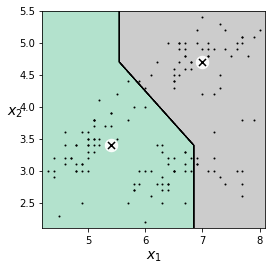

In [5]:
kmedoids = KMedoids(2,24)
kmedoids.fit(data)
plt.figure(figsize=(4, 4))
plot_decision_boundaries(kmedoids, data)
plt.show()

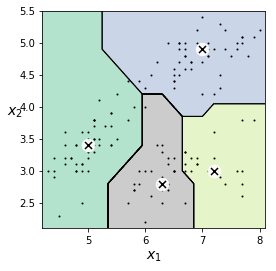

In [6]:
kmedoids = KMedoids(4,23)
kmedoids.fit(data)
plt.figure(figsize=(4, 4))
plot_decision_boundaries(kmedoids, data)
plt.show()

# Note

When predicting labels, it should calculate the distances between test data points X and centers. 

It should not call the \_assign_labels() method which calculates distances of data points already exists in a cluster.
